# Generate LSST filter transmission into PySynPhot
=========================================================================


The purpose is to start to use PySynPhot software to calculate things on
SED, filter transmission,... For Calibration

- Sylvie Dagoret-Campagne
- Affiliation LAL-IN2P3-CNRS
- Work : LSST & StarDice
- date November 21 2017




- Read filters for LSST provided by KG May 30th 2017
- Generate LibRadTran atmosphere for any airmass - H2O - O3 combinations
- Generate the observed spectrum

In [1]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pandas as pd
import os
import re 

In [3]:
import astropy.units as u

In [4]:
os.environ['PYSYN_CDBS']

'/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs'

In [5]:
import sys
sys.path.append('../libradtransim')
sys.path.append('../LSSTFiltersKG')

In [6]:
import libsimulateTranspLSSTScattAbsAer as atm
import libLSSTFiltersKG as lsst

In [7]:
#help(atm)

In [8]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [9]:
import pysynphot as S

# Defining LSST telescope

In [10]:
LSST_COLL_SURF=35*(u.m)**2/(u.cm)**2  # LSST collectif surface
WLMIN=3000.
WLMAX=11000.

In [11]:
LSST_COLL_SURF.decompose()

<Quantity 350000.0>

In [12]:
S.refs.showref()

thermtable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/tae17277m_tmt.fits
   waveset: Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True
 comptable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/16n1832tm_tmc.fits
graphtable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/14l1632sm_tmg.fits
      area: 45238.93416


In [13]:
S.refs.setref(area=LSST_COLL_SURF.decompose(), waveset=None)

In [14]:
S.refs.set_default_waveset(minwave=3000, maxwave=11000, num=8000, delta=1, log=False)

In [15]:
S.refs.showref()

thermtable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/tae17277m_tmt.fits
   waveset: Min: 3000, Max: 11000, Num: None, Delta: 1, Log: False
 comptable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/16n1832tm_tmc.fits
graphtable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/14l1632sm_tmg.fits
      area: 350000.0


## LSST effective filter


In [16]:
bp_u,bp_g,bp_r,bp_i,bp_z,bp_y4=lsst.GetAllLSSTBands('..')

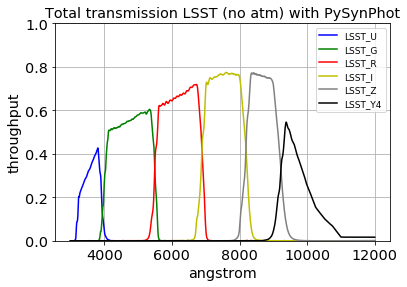

In [17]:
lsst.PlotAllLSSTBands(bp_u,bp_g,bp_r,bp_i,bp_z,bp_y4)

## Read atmosphere

In [18]:
path,thefile=atm.ProcessSimulationaer(1.,4.,300.,500.,1.0) 

--------------------------------------------
 1) airmass =  1.0
 2) pwv =  4.0
 3) oz =  300.0
 4) wl0 =  500.0
 5) tau0 =  1.0
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv40_oz30_aer100.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv40_oz30_aer100.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv40_oz30_aer100.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv40_oz30_aer100.OUT')


In [19]:
fullfilename=os.path.join(path,thefile)

In [20]:
atm_data=np.loadtxt(fullfilename)

In [21]:
wl_atm=atm_data[:,0]
tr_atm=atm_data[:,1]

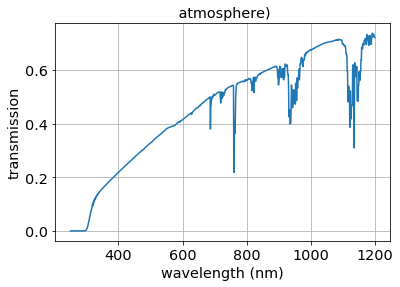

In [22]:
plt.plot(wl_atm,tr_atm)
plt.grid()
plt.title(" atmosphere)")
plt.xlabel("wavelength (nm)")
plt.ylabel("transmission")
plt.savefig("atm-transm.png")

# Pysynphot

In [23]:
bp_atm= S.ArrayBandpass(wl_atm*10.,tr_atm, name='LSST_ATM')

In [24]:
bp_u_atm = bp_u*bp_atm
bp_g_atm = bp_g*bp_atm
bp_r_atm = bp_r*bp_atm
bp_i_atm = bp_i*bp_atm
bp_z_atm = bp_z*bp_atm
bp_y4_atm = bp_y4*bp_atm

In [25]:
bp_u_atm.binning=10.
bp_g_atm.binning=10.
bp_r_atm.binning=10.
bp_i_atm.binning=10.
bp_z_atm.binning=10.
bp_y4_atm.binning=10.

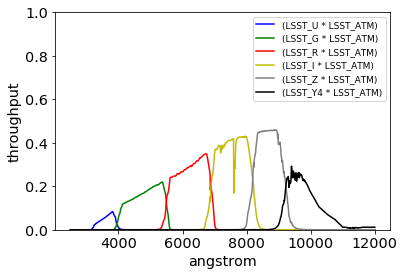

In [26]:
plt.plot(bp_u_atm.wave, bp_u_atm.throughput, 'b')
plt.plot(bp_g_atm.wave, bp_g_atm.throughput, 'g')
plt.plot(bp_r_atm.wave, bp_r_atm.throughput, 'r')
plt.plot(bp_i_atm.wave, bp_i_atm.throughput, 'y')
plt.plot(bp_z_atm.wave, bp_z_atm.throughput, color='grey')
plt.plot(bp_y4_atm.wave, bp_y4_atm.throughput,'k')
plt.ylim(0, 1.)
plt.xlabel(bp_u_atm.waveunits)
plt.ylabel('throughput')
plt.legend([bp_u_atm.name, bp_g_atm.name,bp_r_atm.name, bp_i_atm.name,bp_z_atm.name, bp_y4_atm.name], loc=1,fontsize=9)

# Observation

## Defines the SED

In [27]:
filename = os.path.join(os.environ['PYSYN_CDBS'], 'calspec', 'hd111980_stis_003.fits')
sed = S.FileSpectrum(filename)
sed.flux

array([  2.16790002e-14,   2.66180002e-14,   2.03460007e-14, ...,
         9.32662788e-19,   9.23448099e-19,   9.14324504e-19])

In [28]:
bp_sed=S.ArrayBandpass(sed.wave,sed.flux, name='SED')

Text(0.5,1,u'hd111980_stis_003.fits')

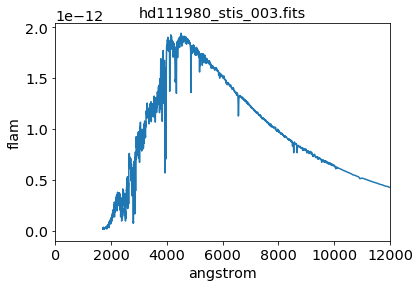

In [29]:
plt.plot(sed.wave,sed.flux)
plt.xlim(0.,12000)
plt.xlabel(sed.waveunits)
plt.ylabel(sed.fluxunits)
plt.title(os.path.basename(sed.name))

- flam unit is erg per sec per cm2 per angstrom

## Defines the transmission

In [30]:
bp_u_atm_sed = bp_u*bp_atm*bp_sed
bp_g_atm_sed = bp_g*bp_atm*bp_sed
bp_r_atm_sed = bp_r*bp_atm*bp_sed
bp_i_atm_sed = bp_i*bp_atm*bp_sed
bp_z_atm_sed = bp_z*bp_atm*bp_sed
bp_y4_atm_sed = bp_y4*bp_atm*bp_sed

## Defines the observation

In [31]:
obs_u = S.Observation(sed,bp_u_atm)
obs_g = S.Observation(sed,bp_g_atm)
obs_r = S.Observation(sed,bp_r_atm)
obs_i = S.Observation(sed,bp_i_atm)
obs_z = S.Observation(sed,bp_z_atm)
obs_y4 = S.Observation(sed,bp_y4_atm)

((LSST_U * LSST_ATM)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((LSST_G * LSST_ATM)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((LSST_R * LSST_ATM)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((LSST_I * LSST_ATM)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((LSST_Z * LSST_ATM)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((LSST_Y4 * LSST_ATM)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


## Defines the collecting area

In [32]:
obs_u.primary_area=LSST_COLL_SURF.decompose()
obs_g.primary_area=LSST_COLL_SURF.decompose()
obs_r.primary_area=LSST_COLL_SURF.decompose()
obs_i.primary_area=LSST_COLL_SURF.decompose()
obs_z.primary_area=LSST_COLL_SURF.decompose()
obs_y4.primary_area=LSST_COLL_SURF.decompose()

In [33]:
print obs_u.primary_area
print obs_g.primary_area
print obs_r.primary_area
print obs_i.primary_area
print obs_z.primary_area
print obs_y4.primary_area

350000.0
350000.0
350000.0
350000.0
350000.0
350000.0


## Plot the observation

Text(0.5,1,u'hd111980_stis_003.fits * (LSST_U * LSST_ATM)')

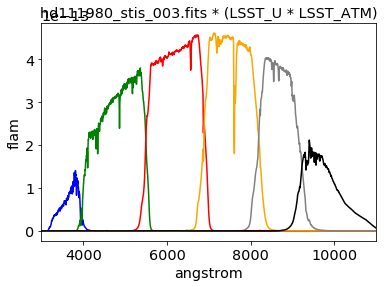

In [34]:
plt.plot(obs_u.wave,obs_u.flux,'b')
plt.plot(obs_g.wave,obs_g.flux,'g')
plt.plot(obs_r.wave,obs_r.flux,'r')
plt.plot(obs_i.wave,obs_i.flux,color='orange')
plt.plot(obs_z.wave,obs_z.flux,color='grey')
plt.plot(obs_y4.wave,obs_y4.flux,'k')
plt.xlim(WLMIN,WLMAX)
plt.xlabel(obs_u.waveunits)
plt.ylabel(obs_u.fluxunits)
plt.title(os.path.basename(obs_u.name))

- flam unit is erg per sec per cm2 per angstrom

- observation is the same as calculating transmission x SED : it as the same unit in erg/s/cm^2

Text(0.5,1,u'((LSST_U * LSST_ATM) * SED)')

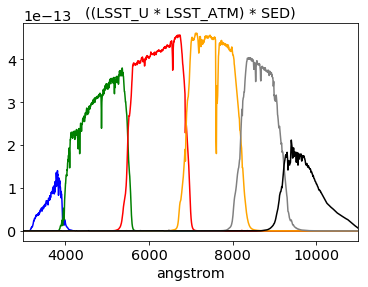

In [35]:
plt.plot(bp_u_atm_sed.wave,bp_u_atm_sed.throughput,'b')
plt.plot(bp_g_atm_sed.wave,bp_g_atm_sed.throughput,'g')
plt.plot(bp_r_atm_sed.wave,bp_r_atm_sed.throughput,'r')
plt.plot(bp_i_atm_sed.wave,bp_i_atm_sed.throughput,color='orange')
plt.plot(bp_z_atm_sed.wave,bp_z_atm_sed.throughput,color='grey')
plt.plot(bp_y4_atm_sed.wave,bp_y4_atm_sed.throughput,'k')
plt.xlim(WLMIN,WLMAX)
plt.xlabel(bp_u_atm_sed.waveunits)
#plt.ylabel(bp_u_atm_sed.fluxunits)
plt.title(os.path.basename(bp_u_atm_sed.name))

/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/calspec/hd111980_stis_003.fits * (LSST_U * LSST_ATM)


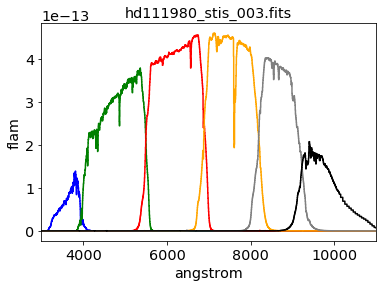

In [36]:
plt.plot(obs_u.binwave,obs_u.binflux,'b',drawstyle='steps-mid')
plt.plot(obs_g.binwave,obs_g.binflux,'g',drawstyle='steps-mid')
plt.plot(obs_r.binwave,obs_r.binflux,'r',drawstyle='steps-mid')
plt.plot(obs_i.binwave,obs_i.binflux,color='orange',drawstyle='steps-mid')
plt.plot(obs_z.binwave,obs_z.binflux,color='grey',drawstyle='steps-mid')
plt.plot(obs_y4.binwave,obs_y4.binflux,'k',drawstyle='steps-mid')
plt.xlabel(obs_u.waveunits)
plt.ylabel(obs_u.fluxunits)
plt.xlim(WLMIN,WLMAX)
plt.title(os.path.basename(sed.name))
print obs_u.name

In [37]:
print obs_u.primary_area

350000.0


### Magnitude

In [38]:
from scipy.interpolate import interp1d

In [74]:
NBINS=100000
BinWidth=(WLMAX-WLMIN)/float(NBINS)
wl=np.linspace(WLMIN,WLMAX,NBINS)

In [75]:
interp_u=f_u=interp1d(obs_u.wave,obs_u.flux,kind='cubic')
interp_g=f_u=interp1d(obs_g.wave,obs_g.flux,kind='cubic')
interp_r=f_u=interp1d(obs_r.wave,obs_r.flux,kind='cubic')
interp_i=f_u=interp1d(obs_i.wave,obs_i.flux,kind='cubic')
interp_z=f_u=interp1d(obs_z.wave,obs_z.flux,kind='cubic')
interp_y4=f_u=interp1d(obs_y4.wave,obs_y4.flux,kind='cubic')

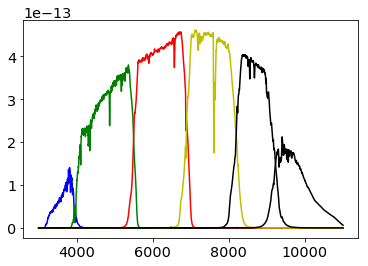

In [76]:
plt.plot(wl,interp_u(wl),'b-')
plt.plot(wl,interp_g(wl),'g-')
plt.plot(wl,interp_r(wl),'r-')
plt.plot(wl,interp_i(wl),'y-')
plt.plot(wl,interp_z(wl),'k-')
plt.plot(wl,interp_y4(wl),'k-')

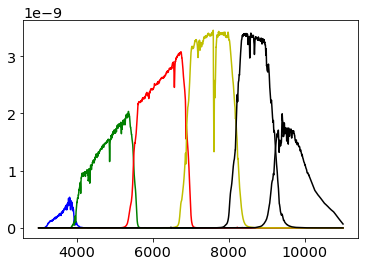

In [77]:
plt.plot(wl,interp_u(wl)*wl,'b-')
plt.plot(wl,interp_g(wl)*wl,'g-')
plt.plot(wl,interp_r(wl)*wl,'r-')
plt.plot(wl,interp_i(wl)*wl,'y-')
plt.plot(wl,interp_z(wl)*wl,'k-')
plt.plot(wl,interp_y4(wl)*wl,'k-')

In [78]:
def CountRate(wl,fl):
    dlambda=BinWidth 
    df=wl*fl*LSST_COLL_SURF/(S.units.C*S.units.H)*dlambda
    # (erg/s/cm2/Angstrom) x (Angstrom)  x  (cm^2) / (erg . s . Angstrom /s) * Angstrom
    # units :  s-1
    count=df.sum()
    return count

In [79]:
def InstrumMag(wl,fl):
    m=-2.5*np.log10(CountRate(wl,fl))
    return m

In [80]:
def ComputeColor(wl,fl1,fl2):
    m1=InstrumMag(wl,fl1)
    m2=InstrumMag(wl,fl2)
    return m1-m2

In [81]:
CountRate(wl,interp_g(wl)).decompose()

<Quantity 38049781.657207124>

In [82]:
CountRate(wl,interp_r(wl)).decompose()

<Quantity 64784822.59565801>

In [83]:
obs_g.countrate('obmag')

<Quantity 38440066.27691173>

In [84]:
obs_r.countrate('obmag')

<Quantity 64837492.85160381>

In [85]:
MyMgMr=ComputeColor(wl,interp_g(wl),interp_r(wl))
print MyMgMr

0.577802762168


In [86]:
-2.5*np.log10(obs_g.countrate('obmag')/obs_r.countrate('obmag'))

<Quantity 0.5676052133223685>

In [87]:
mr=obs_r.effstim('obmag') 

In [88]:
mg=obs_g.effstim('obmag') 

In [89]:
mr-mg

-0.5676044991805256

In [94]:
obs_g.countrate('vegamag')

<Quantity 38440066.27691173>

# Ne pas utiliser les magnitudes calculées par PySynPhot !!!!

# Reference data

In [90]:
 S.showref()

thermtable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/tae17277m_tmt.fits
   waveset: Min: 3000, Max: 11000, Num: None, Delta: 1, Log: False
 comptable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/16n1832tm_tmc.fits
graphtable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/14l1632sm_tmg.fits
      area: 350000.0


# Catalog

In [91]:
from astropy.io import fits
filename = os.path.join(os.environ['PYSYN_CDBS'], 'calspec', 'hd111980_stis_003.fits')
with fits.open(filename) as pf:
    print(pf[1].header)

XTENSION= 'BINTABLE'           /Written by IDL:  Wed Dec 24 09:03:03 2014       BITPIX  =                    8 /                                                NAXIS   =                    2 /Binary table                                    NAXIS1  =                   30 /Number of bytes per row                         NAXIS2  =                 3739 /Number of rows                                  PCOUNT  =                    0 /Random parameter count                          GCOUNT  =                    1 /Group count                                     TFIELDS =                    7 /Number of columns                               EXTNAME = 'SCI     '           /                                                EXTVER  =                    1 /                                                INHERIT =                    T /                                                TFORM1  = '1D      '           /Real*8 (double precision)                       TTYPE1  = 'WAVELENGTH'         /Label fo